#Restricted Boltzmann Machine
* based on "A Practical Guide to Training Restricted Boltzmann Machines" by Hinton
* https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf

##loading data

In [15]:
using MNIST # hand written digits

trainX, trainY = traindata();
testX, testY = testdata();

# limit the dataset for demonstration purpose
trainX = trainX[:,1:5000]
trainY = trainY[1:5000]

testX = testX[:,1:1000]
testY = testY[1:1000]

print("Number of features: ", size(trainX,1), " (28x28 grey scale image)")
print("\n")
print("Number of training examples: ", size(trainX,2))
print("\n")
print("Number of testing examples: ", size(testX,2))

trainDATA = trainX'
xvalidDATA = testX'
m = size(trainDATA,1)
mcross = size(xvalidDATA,1)
print("")

Number of features: 784 (28x28 grey scale image)
Number of training examples: 5000
Number of testing examples: 1000

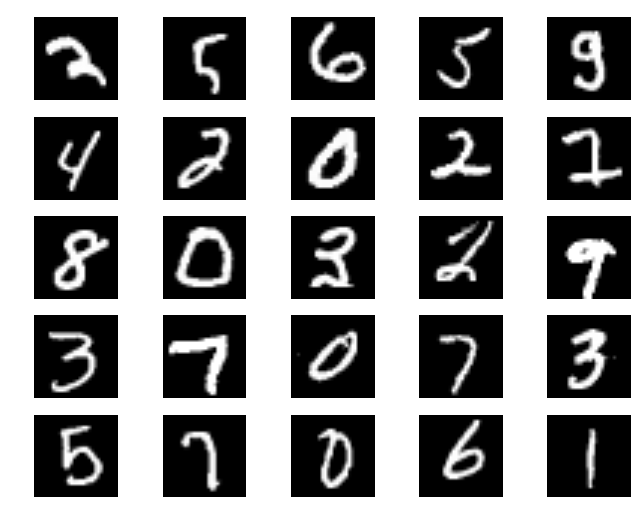

In [16]:
# display random images from the training set
using PyPlot;

for i = 1:25
    PyPlot.subplot(5,5,i)
    PyPlot.axis("off")
    PyPlot.imshow(reshape(trainX'[rand(1:size(trainX',1)),:],28,28), cmap=PyPlot.ColorMap("gray"))
end

##model

In [17]:
hiddenUNITS = 1000 # number of hidden units, ReLU
visibleUNITS = size(trainDATA,2) # number of visible units
learningRATE = 1e-7
CDn = 1 # number of contrastive divergence cycles
miniBATCHexamples = m # size of minibatch
EPOCHS = 500
success = 0.5 # dropout ratio

plotON = true
dropOUT = false
print("")

##adding bias

In [ ]:
trainDATA = hcat(ones(size(trainDATA,1), 1), trainDATA)
xvalidDATA = hcat(ones(size(xvalidDATA,1), 1), xvalidDATA)

In [ ]:
# random initialization
learnedWEIGHTS = 1e-2*randn(visibleUNITS, hiddenUNITS)
learnedWEIGHTS = hcat(zeros(visibleUNITS, 1), learnedWEIGHTS)
learnedWEIGHTS = vcat(zeros(1, hiddenUNITS+1), learnedWEIGHTS)

##training

In [ ]:
trainERROR  = zeros(EPOCHS)
xvalidERROR = zeros(EPOCHS)
binaryMASK  = zeros(miniBATCHexamples, hiddenUNITS+1)
posA1  = zeros(miniBATCHexamples, visibleUNITS+1)
negA1  = zeros(miniBATCHexamples, visibleUNITS+1)
posA2  = zeros(miniBATCHexamples, hiddenUNITS+1)
negA2  = zeros(miniBATCHexamples, hiddenUNITS+1)

using Distributions

tic()
for i = 1:EPOCHS # begin iteration
    
    trainErr = 0
    
    for j = 1:miniBATCHexamples:size(trainDATA,1) # begin loop over minibatches
        rand!(Binomial(1,success),binaryMASK) 
        for CDn_var = 1:CDn # begin loop over CD cycles
            # positive phase
            if CDn_var == 1
                posZ2 = *(trainDATA[j:j+(miniBATCHexamples-1),:], learnedWEIGHTS) # calculate input
                if(dropOUT)
                    posA2 = max(0, posZ2) .* binaryMASK # calculate activation
                else
                    posA2 = max(0, posZ2) # calculate activation
                end
            # negative phase                
                negZ1 = *(posA2, learnedWEIGHTS') # calculate input
            else
                negZ1 = *(negA2, learnedWEIGHTS') # calculate input
                end # end loop over CD cycles 
        
        negA1 = max(0, negZ1) # calculate activation
            negA1[:,1] = 1 # add bias
        negZ2 = *(negA1, learnedWEIGHTS) # calculate input
        if(dropOUT)
            negA2 = max(0, negZ2) .* binaryMASK # calculate activation
        else
            negA2 = max(0, negZ2) # calculate activation
        end
    end # end loop over minibatches
        
    dataEXPECT = *(trainDATA[j:j+(miniBATCHexamples-1),:]', posA2) # data expectation
    modelEXPECT = *(negA1', negA2) # model expectation
    learnedWEIGHTS += learningRATE * ((dataEXPECT - modelEXPECT)/size(trainDATA[j:j+(miniBATCHexamples-1),:],1))
    trainERROR[i] = sum((trainDATA[j:j+(miniBATCHexamples-1),:] - negA1) .^ 2)/size(trainDATA[j:j+(miniBATCHexamples-1),:],1)    
end  # end iteration  
    
    # validation    
    if(dropOUT)
        posZ2 = *(xvalidDATA, success*learnedWEIGHTS) # calculate input
    else
        posZ2 = *(xvalidDATA, learnedWEIGHTS) # calculate input
    end
    
    posA2 = max(0, posZ2) # calculate activation
    negZ1 = *(posA2, learnedWEIGHTS') # calculate input
    negA1 = max(0, negZ1 ) # calculate activation
    xvalidERROR[i] += sum((xvalidDATA - negA1) .^ 2)/size(xvalidDATA,1);
    
    if(i%10==0)
        println("$i")
    end
    
end
toc();

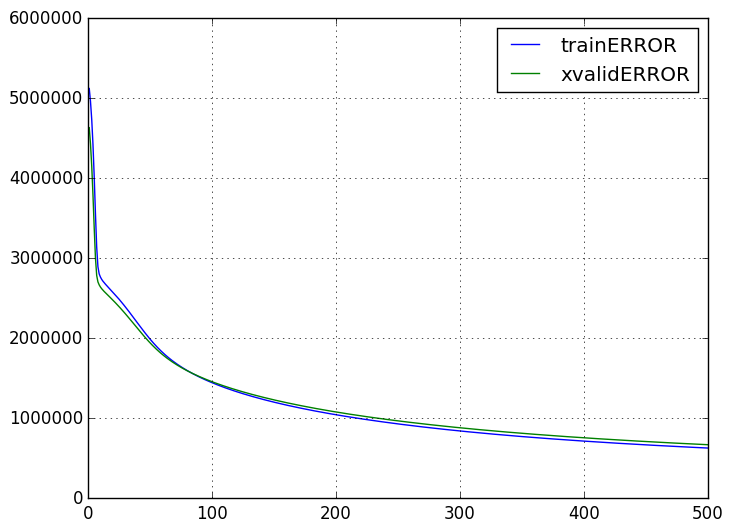

In [21]:
if(plotON)
    plot([1:EPOCHS],trainERROR,label="trainERROR")
    plot([1:EPOCHS],xvalidERROR,label="xvalidERROR")
    legend()
    grid()
end